In [1]:
# Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt

from tensorflow import keras


In [2]:
MODEL_PATH = 'mnist_model.h5'   # Make sure this file exists (exported from digit.ipynb)

# Load model
model = keras.models.load_model(MODEL_PATH)
print("Model loaded:", MODEL_PATH)


Model loaded: mnist_model.h5


Press 'c' to capture digit
Predicted Digit: 3 | Confidence: 0.99


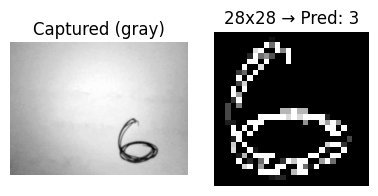

In [4]:

# Resize and center function

def resize_and_center(img, size=28):
    h, w = img.shape
    scale = size / max(h, w)             # Scale digit so largest side = 28
    new_h, new_w = int(h*scale), int(w*scale)
    resized = cv2.resize(img, (new_w, new_h))   # Resize while keeping aspect ratio

    # Create blank black 28x28 canvas
    canvas = np.zeros((size, size), dtype=np.uint8)

    # Center the resized digit inside the canvas
    start_y = (size - new_h) // 2
    start_x = (size - new_w) // 2
    canvas[start_y:start_y+new_h, start_x:start_x+new_w] = resized
    return canvas



# Preprocess captured frame

def preprocess_digit(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)    # Convert to grayscale
    gray = cv2.GaussianBlur(gray, (5,5), 0)           # Blur to remove noise

    # Adaptive threshold → white digit on black background
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)
    
    # Find contours (shapes) → biggest one should be the digit
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None, None, None   # No digit found
    
    # Largest contour = digit
    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    
    # Added padding around the digit
    PAD = 10
    x = max(x - PAD, 0)
    y = max(y - PAD, 0)
    w = w + 2*PAD
    h = h + 2*PAD
    digit = thresh[y:y+h, x:x+w]
    
    # Resize to 28x28 and normalize
    digit28 = resize_and_center(digit)
    normalized = digit28 / 255.0

    # Returns 3 things:
    # (1) Preprocessed image for prediction
    # (2) Original gray image for display
    # (3) Final 28x28 digit for display
    # return normalized.reshape(1,28,28,1), gray, digit28
    return normalized.reshape(1, 28 * 28), gray, digit28




# Opening webcam and capture once

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("  Cannot open webcam")
else:
    print("Press 'c' to capture digit")

while True:
    ret, frame = cap.read()
    if not ret:
        print("  Failed to grab frame")
        break
    
    # Show live webcam feed
    cv2.imshow("Webcam - Press 'c' to capture", frame)
    key = cv2.waitKey(1) & 0xFF
    
    # If user presses 'c' → capture
    if key == ord('c'):
        input_img, gray, digit28 = preprocess_digit(frame)
        if input_img is None:
            print("  No digit detected. Try again")
        else:
            # Make prediction
            probs = model.predict(input_img, verbose=0)[0]
            pred = np.argmax(probs)
            conf = np.max(probs)
            print(f"Predicted Digit: {pred} | Confidence: {conf:.2f}")

            # Show what was captured and what the model saw
            import matplotlib.pyplot as plt
            plt.figure(figsize=(4,2))
            
            plt.subplot(1,2,1)
            plt.imshow(gray, cmap='gray')
            plt.title('Captured (gray)')
            plt.axis('off')
            
            plt.subplot(1,2,2)
            plt.imshow(digit28, cmap='gray')
            plt.title(f'28x28 → Pred: {pred}')
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
        break  # Exit after one capture

cap.release()
cv2.destroyAllWindows()
